# Assignment 4 

In this assignment you will use all three topics covered in the unit, to simulate a type of particle detector known as a drift chamber.

Each part of the assignment can be completed separately, other than the final one where the individual pieces are drawn together. Each part includes necessary background information, followed by some instructions about how to write the code.  Please play particular attention to these sections.

You are expected to use numpy and scipy libraries wherever possible. You will not gain extra marks for writing your own implementation of routines that can be found in numpy/scipy.

The assignment is deliberately open ended, and there are a wide range of extensions that you can explore if you wish - please discuss with your demonstrator or the unit director.

## Introduction - The Drift Chamber

The drift chamber is a type of gas detector used to detect ionising radiation.  It is a variant of the "multi-wire proportional chamber", which was invented by Georges Charpak in 1968, and for which he won the Nobel Prize in 1992.

The basic device is a chamber containing an array of anode wires, as shown in the figure below.  The wires are held at a high voltage with respect to a cathode plate on the other side of the chamber. The chamber is filled with a gas (or sometimes a liquid).  When an ionising particle enters the chamber, it will ionise the gas, producing electrons and positive ions.  The electrons will drift in the electric field, until they reach a wire, which produces a signal that can be measured. By using an array of wires, and precisely recording the time at which a signal arrives, the position of the initial charge can be reconstructed in 2D.  The positive charge will also drift onto the cathode plate, but in this type of chamber, is not recorded.

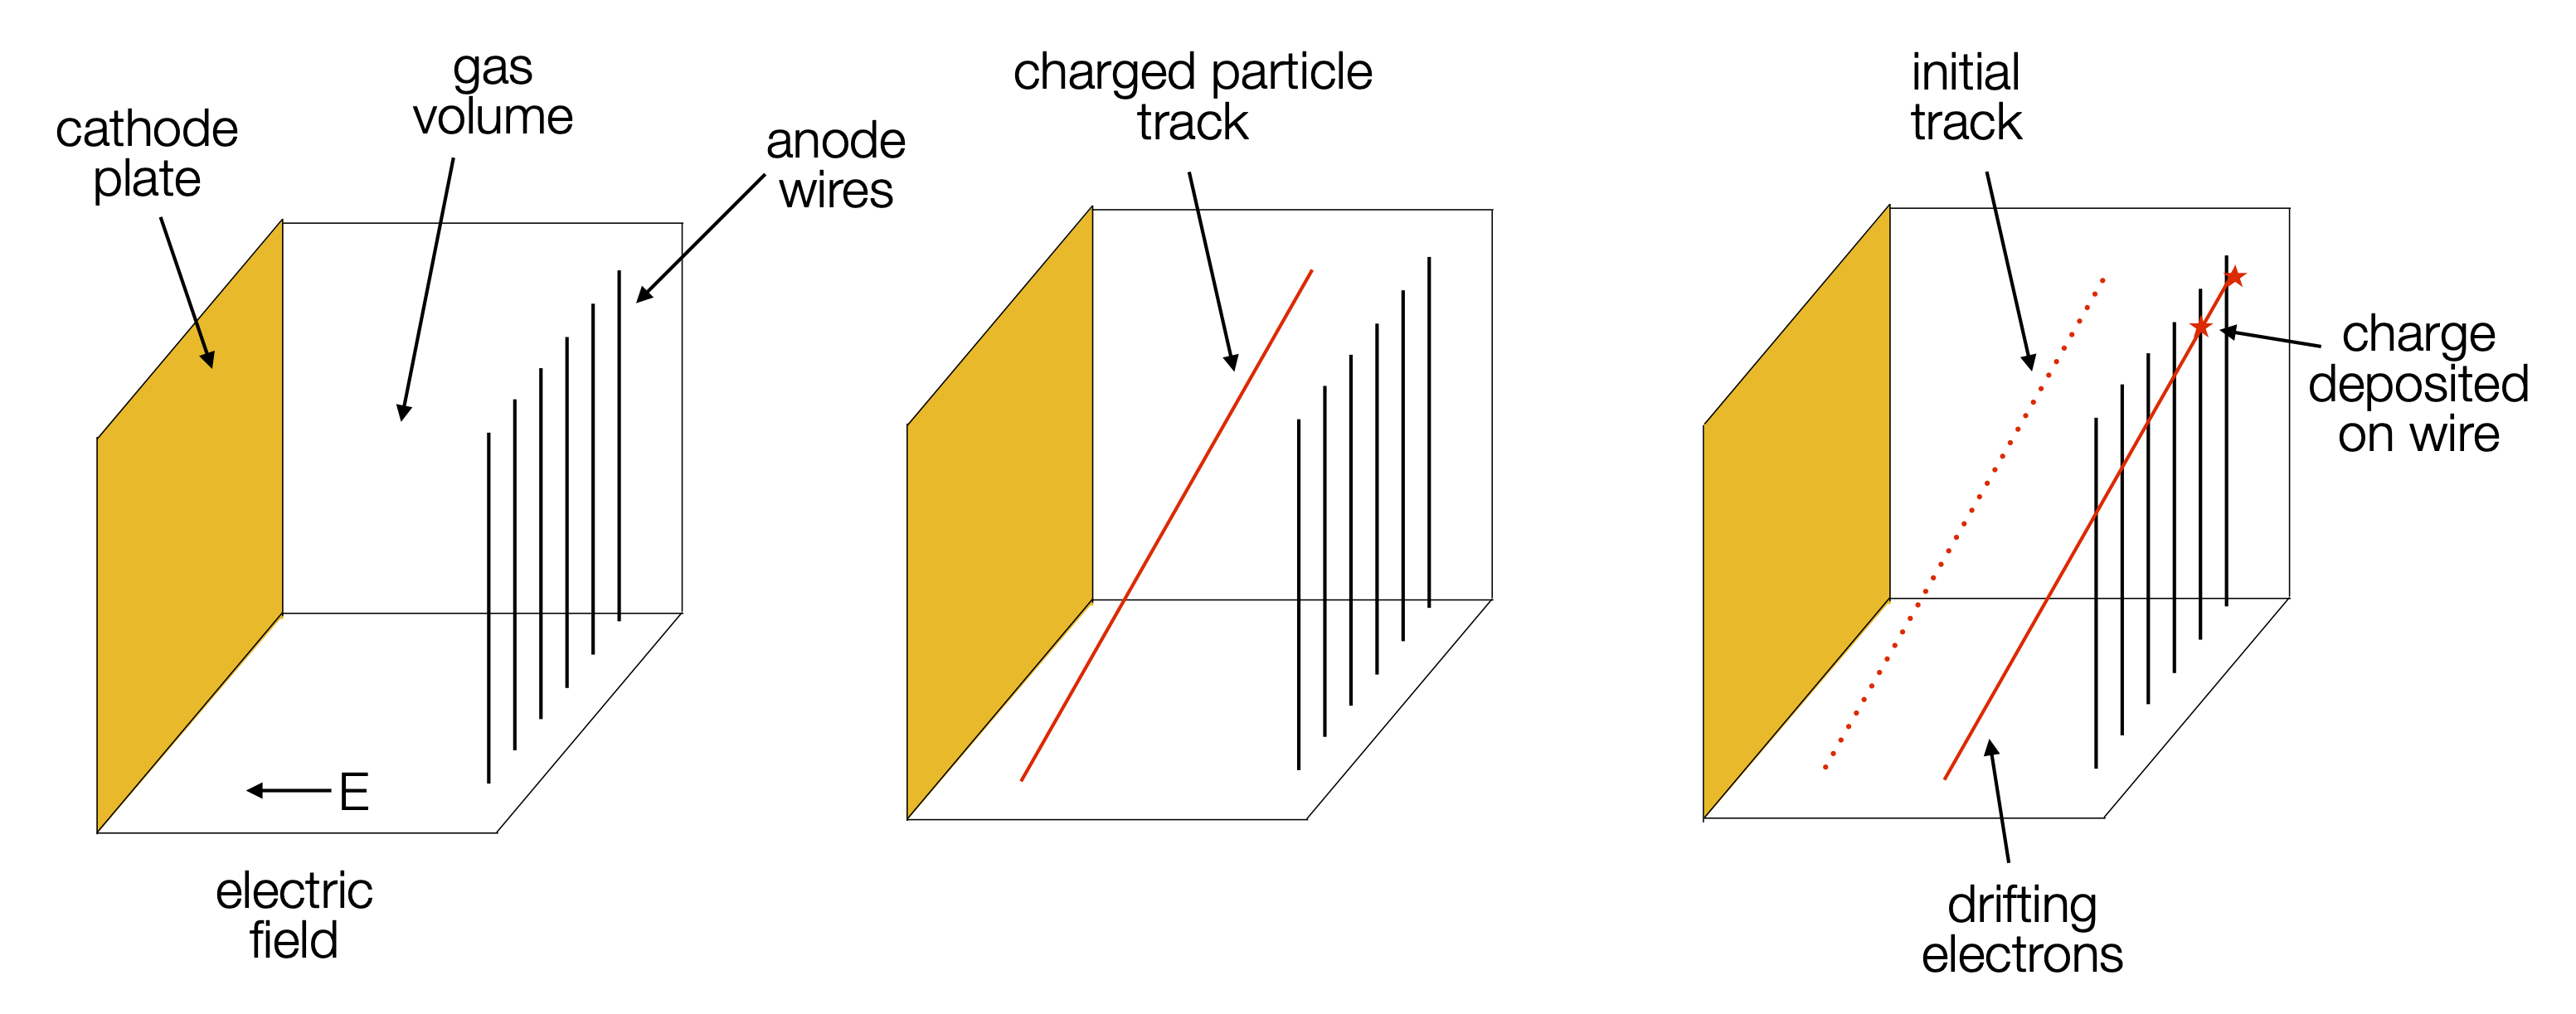

Below is an animation showing the operating principle of a drift chamber. (This particular chamber is a liquid Argon time-projection chamber, in which multiple arrays of wires are used to reconstruct the particle track in 3D.  However the principle is the same as the gaseous Ar detector we will simulate here).

<div>
    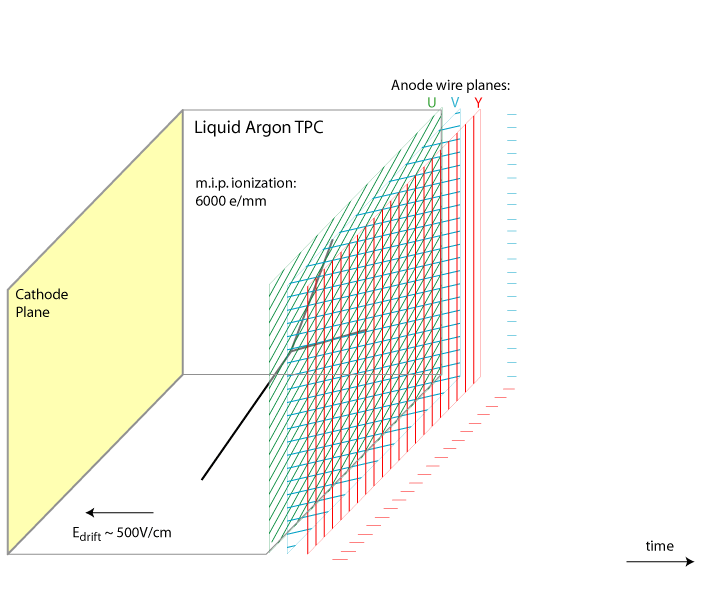
</div>

The particular setup you should simulate is shown in the figure below.

<div>
    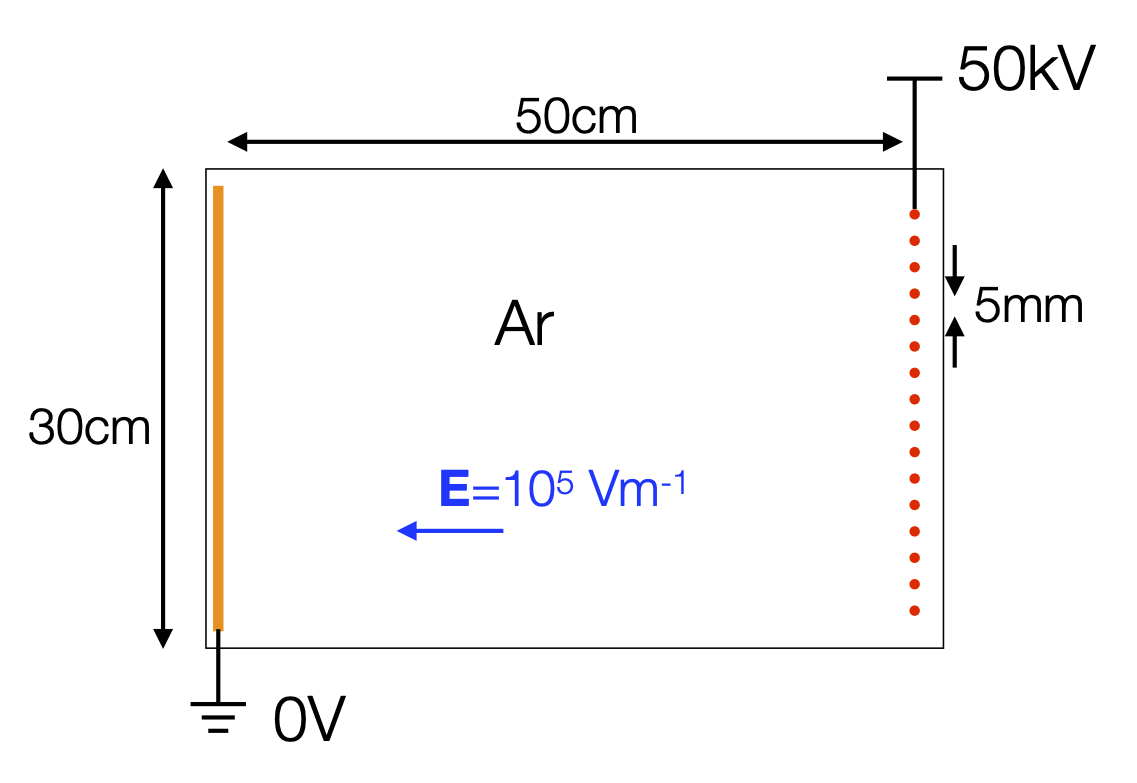
</div>

You can assume the Ar is at normal temperature and pressure (NTP : 293 K, 101 kPa), with electron diffusivity $D = 0.1 \: {\rm m^2s^{-1}}$, electron mobility $\mu=50 \: {\rm m^2V^{-1}s^{-1}}$, and total ionisation (for a cosmic ray muon) of $N_t = 9.4\times10^3$ electrons ${\rm m^{-1}}$. THe electric field within the chamber is $E=10^5 \: {\rm Vm}^{-1}$.

For parts 2-4 we will need to model the distribution of charge in the detector using a discrete grid.  It is suggested you start with a grid spacing of 1cm, which will allow your code to execute reasonably quickly.  Once your code is running, you may wish to decrease the grid spacing.

## Part 1 - Cosmic Ray Generation

In order to simulate the response of the detector, we need a simulation of the incoming particles. Here we will consider cosmic rays, which we will simulate using a Monte Carlo method.

At the Earth's surface, cosmic rays are essential all muons.  To a good approximation, they have a distribution in zenith angle $\theta$ which is proportional to ${\rm cos}^2(\theta)$, and are uniform in azimuthal angle $\phi$. We can assume they are uniformly distributed in the horizontal plane.

If the energy of the cosmic muon needs to be modelled, the distribution can be very crudely approximated in units of GeV/C by a log-normal distribution with $\mu=6.55$ and $\sigma=1.8$.  If the charge needs to be modelled, cosmic rays at the Earth's surface comprise approximately 30% more $\mu^+$ than $\mu^-$.

### Writing the code

Write a function that will randomly generate a cosmic ray muon each time it is called.  The function should return at least a direction in 3D, given the above distributions, as well as a starting position on a user definable horizontal plane.  Show that your function produces the desired distributions, at least qualitatively, by calling it for a large number of trials.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy import linalg
plt.style.use('ggplot')

def randZenithTheta():
    """
    Parameters
    ----------
    None
    
    Returns
    -------
    x : float
        This function generates an angle (theta - the Zenith angle) between
        pi/2 and pi, with PDF cos^2(theta) using the accept/reject method.
        This is used in conjunction with the Azimuth angle, phi, generated
        from the function randAzimuthPhi() to cover the half space trajectory
        of a muon. i.e trajectories that have a positive downward direction.
        
        Units of radians.

    """
    while True:

        x = np.random.random()*((np.pi/2)) + (np.pi/2)
        y = np.random.random()
        if y < np.cos(x)**2:
            return x
        else:
            continue

def randAzimuthPhi():
    """
    Parameters
    ----------
    None
    
    Returns
    -------
    x : float
        This function generates an angle (phi - the Azimuth angle) between
        0 and 2pi,  uniform PDF.
        This is used in conjunction with the Zenith angle, theta, generated
        from the function randZenithTheta() to cover the half space trajectory
        of a muon. i.e trajectories that have a positive downward direction
        (below z = 0).
        
        Units of radians.

    """
    x = np.random.random()*np.pi*2
    
    return x

def randEnergy(mu = 6.55, sigma = 1.8):
    """
    Parameters
    ----------
    mu : float
        This is the mean of the energy log-normal distribution.
    sigma : float
        This is the standard deviation of the energy log-normal distribution.
    
    Returns
    -------
    energy : float
        This function generates a single point of a log-normal distribution 
        for muon energy. To be used in conjuction with list comprehension to 
        establish correct distribution. 
        
        Units of GeV/c.

    """
    energy = np.random.lognormal(mu, sigma)
    
    return energy


def v_unit_vector():
    """
    Parameters
    ----------
    None
    
    Returns
    -------
    coordinates : list of floats
        This function generates a unit vector (in cartesian coordinates) for
        the direction of travel of a muon given the distributions for theta
        and phi, calculated from randZenithTheta() and randAzimuthPhi()
        respectively.This unit vector will only cover the half space trajectory
        of a muon. i.e trajectories that have a positive downward direction
        (below z = 0).
        
        Units of length.

    """
    
    phi = randAzimuthPhi()
    theta = randZenithTheta()
    
    # Coordinate transform from (unit) spherical to (unit) cartesian.
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    
    # Assign coordinates to variable for clarity
    coordinates = [x,y,z]
    
    return coordinates 

def horizontalplane(x_size, y_size, z = 0):
    """
    Parameters
    ----------
    x_size : float
        This is the size of the horizontal plane in the x-direction. 
    y_size : float
        This is the size of the horizontal plane in the y-direction.
    z : float
        This is the height of the horizontal plane along the z-direction.
    
    Returns
    -------
    plane_coordinates : list of floats
        This function generates a coordinate within a horizontal plane. The x and
        y components are uniformly distributed representing any location on
        the plane. Along with the z value, representing the height
        of this plane. This is an x-y plane centered on the origin.
        
        Units of m.

    """

    x = x_size/2
    y = y_size/2
    x_coord = np.random.uniform(-x,x)
    y_coord = np.random.uniform(-y,y)
    
    # Assign coordinates to variable for clarity
    coordinates_plane = [x_coord, y_coord, z]
    
    return coordinates_plane

def generate_Muon(x_size, y_size, z = 0):
    """
    

    Parameters
    ----------
    x_size : float
        This is the size of the horizontal plane in the x-direction. 
    y_size : float
        This is the size of the horizontal plane in the y-direction.
    z : float, optional
        This is the height of the horizontal plane along the z-direction.

    Returns
    -------
    muon_v_unit_vector : list of floats

    muon_position : list of floats
        
    muon_Energy : float
        
        This function generates the direction of the muon as a unit vector
        in cartesian coordinates; its creation position on a horizontal plane;
        and its energy at creation.

    """
    # Assign direction, position and energy to variables for clarity
    muon_v_unit_vector = v_unit_vector()
    muon_position = horizontalplane(x_size, y_size, z)
    muon_energy = randEnergy()
    
    return muon_v_unit_vector, muon_position, muon_energy
    

def plot_labeler(x_label,y_label,title):
    """
    

    Parameters
    ----------
    x_label : string
        This is the label for the x axis of a plot.
    y_label : string
        This is the label for the y axis of a plot
    title : string
        This is the title for a plot.

    Returns
    -------
    This function is used to help reduce clutter, when setting the labelling
    of a plot.

    """
    plt.xlabel(str(x_label))
    plt.ylabel(str(y_label))
    plt.title(str(title))

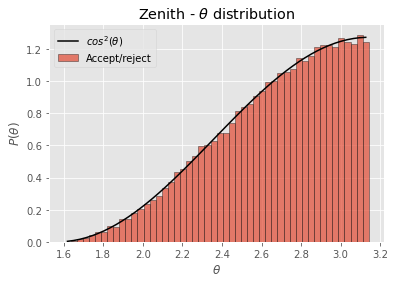

In [2]:
######### Checking the Zenith (theta) and Azimuth (phi) angles. ###########


# Zenith(theta) angle - start ################################################

# Create a list of the distributed Zenith (theta) angles.
values_ZenithTheta = [randZenithTheta() for _ in range(50000)]

# Plot histogram.
hist_ZenithTheta, bins_ZenithTheta, patches_ZenithTheta = plt.hist(  values_ZenithTheta
                                                                   , bins=50
                                                                   , edgecolor='black'
                                                                   , alpha = 0.7
                                                                   , density=True
                                                                   , label="Accept/reject")

# Find the bin centres of the histogram to plot the expected distribution.
bin_centres_ZenithTheta = (bins_ZenithTheta[1:] + bins_ZenithTheta[:-1])/2

# Plot the expected distribution for qualititive analysis.
plt.plot(  bin_centres_ZenithTheta
         , np.cos(bin_centres_ZenithTheta)**2/(np.pi/4) # Normalisation with pi/4
         , color = 'black'
         , label=r'$cos^2(\theta)$')

# Plot parameters for Zenith (theta) angle - start.
plot_labeler(r'$\theta$', r'$P(\theta)$', 'Zenith - $\\theta$ distribution')
plt.legend()
plt.show()
# Plot parameters for Zenith (theta) angle - end.

# Zenith(theta) angle - end  #################################################


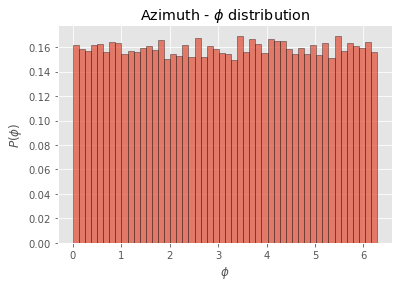

In [3]:
# Azimuth(phi) angle - start #################################################

# Create a list of the distributed Azimuth (phi) angles.
values_AzimuthPhi = [randAzimuthPhi() for _ in range(50000)]

# Plot histogram 
hist_AzimuthPhi, bins_AzimuthPhi, patches_AzimuthPhi = plt.hist(  values_AzimuthPhi
                                                                , bins=50
                                                                , edgecolor='black'
                                                                , alpha = 0.7
                                                                , density=True
                                                                , label="Accept/reject")
# Plot parameters for Azimuth (phi) angle - start.
plot_labeler(r'$\phi$', r'$P(\phi)$', 'Azimuth - $\phi$ distribution')
plt.show()
# Plot parameters for Azimuth (phi) angle - end.

# Azimuth(phi) angle - end  ##################################################


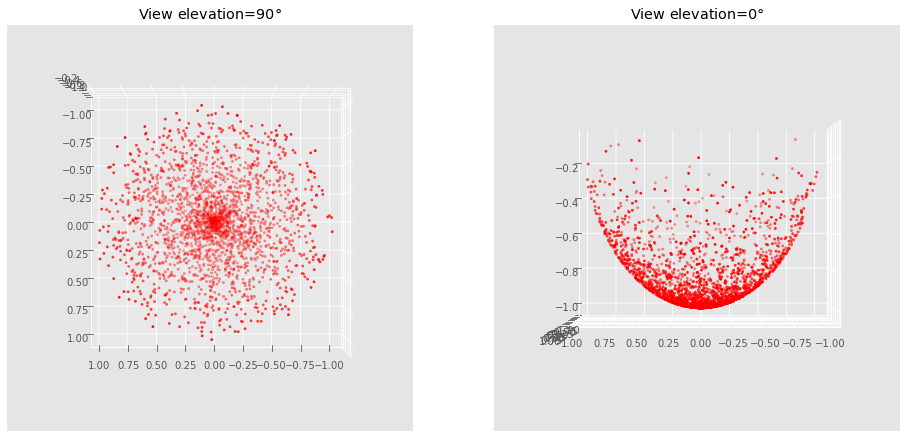

In [4]:
################## Checking unit vector distribution. ########################

# Create a list of the unit vectors for multiple muons.

muon_unit_vector = np.array([v_unit_vector() for _ in range(2500)])

# plot of unit vectors in 3D - start #########################################
# Plot viewed from above (elevtation = 90)
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title(r"View elevation=90$\degree$")
ax1.scatter( muon_unit_vector[:,0]
            , muon_unit_vector[:,1]
            , muon_unit_vector[:,2]
            , marker='.'
            , c='r')
ax1.view_init(elev=90., azim=90)

# Plot viewed from the side (elevation = 0)
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title(r"View elevation=0$\degree$")
ax2.scatter( muon_unit_vector[:,0]
            , muon_unit_vector[:,1]
            , muon_unit_vector[:,2]
            , marker='.', c='r')
ax2.view_init(elev=0., azim=90)

plt.show()
# plot of unit vectors in 3D - end ###########################################


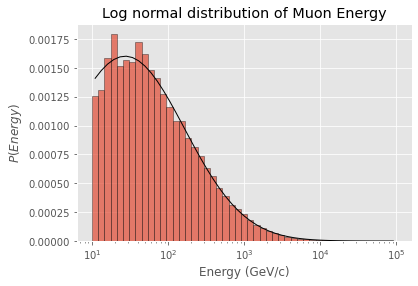

In [5]:
##################### Checking energy distribution. ##########################

# This is a log-normal distribution

mu = 6.55 # Mean.
sigma = 1.8 # Standard deviation

# Create a list of the energies for multiple muons.
values_energy = [randEnergy(mu, sigma) for _ in range(50000)]

# Plot histogram.
hist_energy, bins_energy, patches_energy = plt.hist(values_energy
                                                    , bins=np.logspace(1, 5, 50)
                                                    , density=True
                                                    , edgecolor='black'
                                                    , alpha = 0.7)

# Find the bin centres of the histogram to plot the expected distribution.
bins_centres_energy = (bins_energy[1:] + bins_energy[:-1]) / 2

# Plot the expected distribution for qualititive analysis.
pdf_exp_arg = (-(np.log(bins_centres_energy) - mu)**2 / (2 * sigma**2))
pdf_denominator = (bins_centres_energy * sigma * np.sqrt(2 * np.pi))
pdf = (np.exp(pdf_exp_arg) / pdf_denominator )

plt.xscale('log')
plt.plot(bins_centres_energy, pdf, linewidth=1, color='black')
plot_labeler(  "Energy (GeV/c)"
             , '$P(Energy)$'
             , 'Log normal distribution of Muon Energy')


In [6]:
# Generate a muon
muon_unit_vector, muon_position, muon_energy  =  generate_Muon(1,1)

print("Muon unit vector (x,y,z): " + str(muon_unit_vector))
print("Muon starting position coordinates (x,y,z), metres: " + str(muon_position))
print("Muon starting energy, GeV/c: " + str(muon_energy))

Muon unit vector (x,y,z): [-0.21684628326974328, 0.19467619562582572, -0.9565975477120738]
Muon starting position coordinates (x,y,z), metres: [-0.45790281157053725, -0.3918325873700029, 0]
Muon starting energy, GeV/c: 662.9938577532619


## Part 1: Description of code

The code in Part 1 is used to both generate a cosmic muon and to qualitatively observe that the correct distributions are made when running each section for a large number of trials.

The muon is generated by using a cos^2 distribution for the zenith angle (theta) and a uniform distribution for the azimuth angle (phi).

For the zenith angle, the function randZenithTheta() is used. It outputs a value for the zenith angle with a cos^2 distribution. To cover a halfspace for the muon trajectory and range from pi/2 to pi radians is used. This is because I will be generating these muons above the detector and therefore any muons that have a trajectory in the positive z direction will always miss the detector. This works by generating a random value between pi/2 and pi and then using the accept/reject method for the cos^2 distribution. This is ran 50000 using list comprehension and normalised. The expected cos^2 distribution is plotted over the same graph using the bin centres for the argument of the distribution. This was normalised by dividing by pi/4.

For the azimuth angle, the function randAzimuthPhi() is used. It outputs a value for the azimuth angle with a uniform distribution. To completely cover the desired halfspace a range of 0 to 2pi is used. This is a very simple method using np.random.random(). This is then analysed in the same way as for the zenith angle. Though this time the expected uniform distribution is not plotted over the data as it is a simple straight line and easily observed visually.

Next the angles are further checked to see if they describe the desired halfspace. A coordinate transform from spherical to cartesian is used to create a unit vector. This is done using the function v_unit_vector(). Two 3d plots are created after generating 2500 sets of unit vectors. One from above and one from the front.

Finally, a muon is generated using the generate_Muon() function, this generates a direction (muon_unit_vector), a position on a horizontal plane (generated by the function horizontalplane()) and an energy (from the function randEnergy() – see extension).

Extension:
The energy distribution was modelled using a log-normal distribution. This was calculated using the randEnergy() function and simply uses np.random.lognormal(). This was qualitatively analysed by plotting the expected distribution over the same graph using the bin centres as the arguments for the distribution calculated (labelled pdf).



## Part 1: Discussion of results
### Angles
#### Zenith – theta
First the zenith angle was calculated 50,000 times between the angle’s pi/2 and pi (radians). This was normalised by setting the density = True in the histogram plot. The data can then be qualitatively compared to the cos^2 distribution. Looking at the Zenith - \theta distribution plot It can be seen that indeed the distribution of randZenithTheta() does match the desired distribution very closely. It does have slightly larger deviations for larger values for theta, but these are negligible and will smooth out as you increase the number of trials.

#### Zenith – theta
Next, the azimuth angle was calculated 50,000 times between the angle’s 0 and 2pi (radians). This was normalised by setting the density = True in the histogram plot.  Looking at the Azimuth - \phi distribution plot It can be seen that indeed the distribution of randAzimuthPhi () does match the desired uniform distribution very closely. It does slightly deviate, but this will smooth out as you increase the number of trails, so these deviations are negligible.

### Unit vector
Next, the spherical coordinates are converted to cartesian unit vectors and mapped in a 3d plot with two different viewing angles to properly analyse. From these plots, the plot with a 90 degree view elevation show what is expected when considered a uniform azimuth angle as it has circular symmetry. The concentration near the centre is also what is expected when taking into account the zenith cos^2 distribution. These unit vectors will concentrate near the centre which is further seen when looking at the plot with a view elevation of 0 degrees. This is exactly the distribution that I was expecting/aiming for. All the unit vectors have a downward direction, which is also correct a I will be using this to represent muons coming down from the sky.

### Extension – energy distribution
Finally, the energy of the muon was modelled as an extension to part 1. This is modelled via a log-normal distribution. 50,000 values were generated and plotted on a normalised histogram alongside the probability distribution function (pdf) for a log normal function. As can been seen from the plot “log normal distribution of Muon Energy” the data fits this distribution very closely. With slight deviation for small energy values.



## Part 2 - Ionisation

When a charged particle, such as a cosmic ray muon, traverses the wire chamber, it will ionise gas molecules. In order to model this ionisation, we can assume the muon loses negligible energy while traversing the detector, and liberates a fixed number of electrons per unit distance. For the Ar in the drift chamber we are modelling, you can assume 94 electrons are liberated per cm.  (A more sophisticated extension would use a Monte Carlo method to model variations in the number of liberated electrons as the muon traverses the chamber.)

### Writing the code

You should write a function which takes the starting position and direction of a randomly generated cosmic ray as input, and returns a 2D array representing the initial ionisation caused by the cosmic ray.  In order to achieve this, you may wish to first write a function which calculates the length of a track traversing a grid cell, given the track parameters and grid cell location. You should test your code by generating a few cosmic rays and plotting the resulting charge distribution.

In [7]:
def check_chamber_entry(x_T,z_L,z_R):
    """
    

    Parameters
    ----------
    x_T : float
        This reffers to the x coordinate of the muon while at the z coordinate
        corresponding to the top of the argon chamber.
    z_L : float
        This reffers to the z coordinate of the muon while at the x coordinate
        corresponding to the left handside of the argon chamber.
    z_R : float
        This reffers to the z coordinate of the muon while at the x coordinate
        corresponding to the right handside of the argon chamber.

    Returns
    -------
    muon_hit : string
        This is a string that passes on the information about whether the muon
        enters any particular side of the argon chamber, or whether it misses.
    coordinate_entry : list of floats
        This is the (x,z) coordinate of where the muon enters the chamber.
        
    This whole function checks if the muon enters the chamber or not, and if it 
    does enter, it will return the coordinates of that entry point. Only the top
    and both sides are checked as it cannot enter from the bottom of the chamber.
    It does this by using the x and z values corresponding to the top and sides
    of the chamber and checking to see if they are within the range of boundaries
    given by the definition/placement/size of the chamber.
    
    """
    
    muon_hit = 'miss'
    
    # Check whether muon enters through the top.
    if x_L < x_T < x_R:
        x_enter = x_T
        z_enter = z_T
        muon_hit = 't'
        print("Muon enters through the top (x,z): ")
    
    # Check sides
    
    # Check whether muon enters through the left side.
    elif z_B < z_L < z_T:
        muon_hit = 'l'
        x_enter = x_L
        z_enter = z_L
        print("Muon enters through the left side (x,z):")
        
    # Check whether muon enters through the right side.
    elif z_B < z_R < z_T:
        muon_hit = 'r'
        x_enter = x_R
        z_enter = z_R
        print("Muon enters through the right side (x,z):")
    
    # If it doesnt intersect with the top or sides, it must miss.
    else:
        #print("Muon misses")
        muon_hit = 'miss'
        return muon_hit, False
     
    # Assign coordinate to variable for clarity 
    coordinate_entry = [x_enter, z_enter]
    return muon_hit, coordinate_entry

def check_chamber_exit(muon_hit, x_B,z_L,z_R):

    """
    

    Parameters
    ----------
    x_B : float
        This reffers to the x coordinate of the muon while at the z coordinate
        corresponding to the bottom of the argon chamber.
    z_L : float
        This reffers to the z coordinate of the muon while at the x coordinate
        corresponding to the left handside of the argon chamber.
    z_R : float
        This reffers to the z coordinate of the muon while at the x coordinate
        corresponding to the right handside of the argon chamber.

    Returns
    -------

    coordinate_exit : list of floats
        This is the (x,z) coordinate of where the muon enters the chamber.
        
    This whole function checks where the muon exits the chamber, it will return
    the coordinates of that exit point. Only the bottom and both sides are
    checked as it cannot exit from the top of the chamber.
    It does this by using the x and z values corresponding to the bottom and sides
    of the chamber and checking to see if they are within the range of boundaries
    given by the definition/placement/size of the chamber.
    
    Conditions are put in place to handle if the muon enters and exits through
    the sides only. With current geometry this wont happen, but if later 
    redifined this will be a problem.
    
    """

    # Check whether muon exits through the bottom.
    if x_L < x_B < x_R:
        x_exit = x_B
        z_exit = z_B
        print("Muon exits through the bottom (x,z):")
    
    # Check sides
    
    # Check left side exit, if it didnt enter through the left side
    if muon_hit != 'l':
        if z_B < z_L < z_T:
            x_exit = x_L
            z_exit = z_L
            print("Muon exits through the left side (x,z):")    
     
    # Check right side exit, if it didnt enter through the right side
    if muon_hit != 'r':
        if z_B < z_R < z_T:
            x_exit = x_R
            z_exit = z_R
            print("Muon exits through the right side (x,z):")
            
    # Assign coordinate to variable for clarity 
    coordinate_exit = [x_exit, z_exit]
    
    return coordinate_exit


        
def bresenham_line(start,end):
    """
    

    Parameters
    ----------
    start : list of integers
        This is set of indexes for a 2D array that corresponds to the (x,z)
        coordinate of where the muon enters the chamber.
    end : list of integers
        This is set of indexes for a 2D array that corresponds to the (x,z)
        coordinate of where the muon exits the chamber.

    Returns
    -------
    coordinates_array : list of a list of integers
        Brensenham line algorithm, this function finds a straight line path,
        from one set of integer coordinates to another, by using this we can
        affectively use it to calculate the indexes of a 2D array corresponding
        to the quantised ionisation chamber (a grid). This returns a set of 
        integer coordinates within a grid for which the line passes closest to.
        
    """
    x = start[0]
    y = start[1]
    x2 = end[0]
    y2 = end[1]
    steep = 0
    coordinates_array = []
    dx = abs(x2 - x)
    if (x2 - x) > 0: 
        sx = 1
    else: 
        sx = -1
    dy = abs(y2 - y)
    if (y2 - y) > 0: 
        sy = 1
    else: 
        sy = -1
    if dy > dx:
        steep = 1
        x,y = y,x
        dx,dy = dy,dx
        sx,sy = sy,sx
    d = (2 * dy) - dx
    for i in range(0,dx):
        if steep:
            coordinates_array.append([y,x])
        else: 
            coordinates_array.append([x,y])
        while d >= 0:
            y = y + sy
            d = d - (2 * dx)
        x = x + sx
        d = d + (2 * dy)
        
    coordinates_array.append([x2,y2])
    return coordinates_array     


def plot_chamber(Chamber, title_add):
    """
    

    Parameters
    ----------
    Chamber : 2D array
        This is the 2D array corresponding to the grid/quantised ionisation 
        chamber.

    Returns
    -------
    This plots the 2D array and labels it.

    """
    fig, ax = plt.subplots()
    im = ax.imshow(Chamber, cmap='BuPu', origin='lower')
    ax.set(title='Ionisation chamber' + str(title_add), xlabel='x array index', ylabel='z array index')
    ax.grid(False)
    cb = plt.colorbar(im)
    cb.set_label('Ionisation (C)')
    
    plt.show()  
    
def plot_labeler(x_label,y_label,title):
    """
    

    Parameters
    ----------
    x_label : string
        This is the label for the x axis of a plot.
    y_label : string
        This is the label for the y axis of a plot
    title : string
        This is the title for a plot.

    Returns
    -------
    This function is used to help reduce clutter, when setting the labelling
    of a plot.

    """
    plt.xlabel(str(x_label))
    plt.ylabel(str(y_label))
    plt.title(str(title))

Muon enters through the top (x,z): 
[-0.2118932578053908, -0.2]
Muon exits through the bottom (x,z):
[-0.18842370532144612, -0.5]


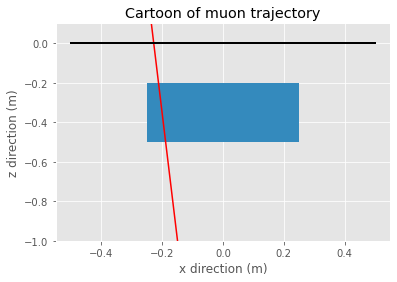

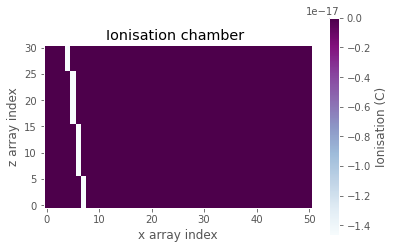

In [8]:
########### Size and placement of horizontal plane and chamber. ##############
z_0 = 0 # Height of horizontal plane, centred on the origin, m.
plane_size_x = 1 # Size of the horizontal plane in the x direction, m.
plane_size_y = 1 # Size of the horizontal plane in the y direction, m.
z_distance = 0.2 # Absolute distance of the plane to top of the chamber, m.

chamber_size_x = 0.5 # Width of the chamber, m.
chamber_size_z = 0.3 # Height of the chamber, m.


z_T = -z_distance # Top of chamber, m.
z_B = -z_distance - chamber_size_z # Bottom of chamber, m.
x_L = -chamber_size_x/2 # Left side of chamber, m.
x_R = chamber_size_x/2 # Right side of chamber, m.

##############################################################################

muon_hit_direction = 'miss'
# Keep generating muons until one intersects with the chamber.
while muon_hit_direction == 'miss':
    # Generate a muon.
    muon_unit_vector, muon_position, muon_energy  =  generate_Muon(1,1,z_0)


    # Calculate gradient and intercept of muon trajectory.
    delta_z = muon_unit_vector[2]
    delta_x = muon_unit_vector[0]
    gradient = delta_z/delta_x # Gradient of muon trajectory
    c = z_0 - (gradient * muon_position[0]) # z intercept.

    # Find potential intersecting coordinates of the muon and the chamber.
    x_T = (z_T - c)/gradient # x coordinate if z is at the top of the chamber.
    x_B = (z_B - c)/gradient # x coordinate if z is at the bottom of the chamber.
    z_R = gradient * x_R + c # z coordinate if x is at the right side of chamber.
    z_L = gradient * x_L + c # z coordinate if x is at the left side of chamber.



    # Check to see if the muon enters the chamber
    muon_hit_direction, entry_coords = check_chamber_entry(x_T, z_L, z_R)

print(entry_coords)
# Check where the muon exits the chamber.
exit_coords = check_chamber_exit(muon_hit_direction, x_B, z_L, z_R)
print(exit_coords)

# 2D plot of the muon trajectory, plane and chamber as seen from the x-z plane.
fig = plt.figure() 
ax = fig.add_subplot(111)
ax.add_patch(Rectangle((x_L, z_B), 0.5, 0.3)) # Adds the chamber as rectangle
x = np.linspace(-plane_size_x/2, plane_size_x/2,10) # Horizontal plane. 
y = gradient*x+c # Muon trajectory.

# Plot parameters
plt.plot(x, y, '-r') # Plot trajectory/
plt.plot([ -plane_size_x/2
         , plane_size_x/2]
         , [0, 0]
         , color='k'
         , linestyle='-'
         , linewidth=2) #  Plot the side view of horizontal plane.
plot_labeler('x direction (m)', 'z direction (m)', 'Cartoon of muon trajectory')
plt.ylim(top=0.1) # Keeping the graph size constant
plt.ylim(bottom=-1) # Keeping the graph size constant
plt.show()


sq_size = 0.01 # Size of grid spaceing within chamber.
electrons_per_m = 9400 # Number of electrons per metre.

# Create Argon chamber as a 2D array, representing a grid of spacing sq_size.
chamber_grid = np.zeros([ int(chamber_size_z/sq_size+1)
                        , int(chamber_size_x/sq_size)+1])

# Transform entry coordinates into indexes within a 2D array.
# This is a quantisation of the coordinate systems, followed by a
# translation of the coordinates so they are in a second reference frame,
# with the origin centered on the bottom left of the ionisation chamber.
# These quantised coordinates in the translated frame then correspond
# to the indexes within the 2D array.
index_x_init = int(chamber_size_x /(2*sq_size) + int(entry_coords[0] / sq_size))
index_z_init = int((z_distance + chamber_size_z) / sq_size) + int(entry_coords[1] / sq_size) 

# Transformed and translated entry coordinates into indexes for 2D array.
start = [index_x_init, index_z_init]

# Exit coordinates treated the same as what was done for the entry coordinates.
index_x_end = int(chamber_size_x /(2*sq_size)) + int(exit_coords[0] / sq_size)
index_z_end = int((z_distance + chamber_size_z) / sq_size) + int(exit_coords[1] / sq_size) 

# Transformed and translated exit coordinates into indexes for 2D array.
end = [index_x_end, index_z_end]

# Electron parameters
e_charge = -1.602176634e-19
e_per_m = 9400

# This impliments the contribution of the y component of the muon trajectory.
entry_point_3d = np.array([entry_coords[0], 0., entry_coords[1]])
delta_y = (exit_coords[1] - entry_coords[1]) * (muon_unit_vector[1] / muon_unit_vector[2])

exit_point_3d = np.array([exit_coords[0], delta_y, exit_coords[1]])

length = np.linalg.norm(exit_point_3d - entry_point_3d) # Length of trajectory in 3D.

# Total electrons liberated by the muon through the whole chamber.
electron_number = length * e_per_m 

# Assigns charge to grid chamber based on bresenham_line() index coordinates.
for i in range(len(bresenham_line(start, end))):
    point = bresenham_line(start, end)[i] # Index coordinates.
    x_pos = point[0] # x component of index.
    z_pos = point[1] # z component of index.

    # Allocates the average number of electrons per grid section liberated
    chamber_grid[z_pos, x_pos] = e_charge * electron_number/len(bresenham_line(start, end))  

# Plot chamber
plot_chamber(chamber_grid, " ")

## Part 2: Description of code

The code in Part 2 is used to generate a muon and simulate its trajectory through an ionisation chamber. This works by first generating a muon using the generate_Muon() function inside a while loop. This while loop is to ensure that only muons with a trajectory that intercepts the chamber go on to be analysed. It will however, give a quick print-out for the incidents where it does miss. First, the parameters for the horizontal plane and chamber size and placement are stipulated. The current settings have the horizontal plane (1m^2) placed in the x-y plane at z=0 centred on the origin. The chamber is then placed 20cm below this, also centred on the origin. From the information generated by generate_Muon(), the direction and starting position are used to calculate the gradient and z- intercept of the trajectory. This information is then plugged into the line equation to find the x coordinate when at the top and bottom of the chamber and the z coordinate when at the sides of the chamber.

This information is fed into check_chamber_entry(), this function checks to see if the respective coordinates show a intersection between the muon trajectory and the chamber. If they do intersect the while loop finishes and then the function check_chamber_exit() calculates where the muon will exit the chamber. A brief description of its entry and exit points are printed along with the coordinates in (x,z).

A graph is then plotted of the 2D representation of the whole problem for better visualisation (labelled “Cartoon of muon trajectory”).

Next then, is representing this trajectory through an ionisation chamber. To do this the chamber space is quantised into a grid with test spacing of 1cm. This is done by creating a 2D array (chamber_grid) with a size that matches the quantisation of the chamber, simply done by taking the chamber sizes and creating discrete sections by dividing by the grid spacing. Now each value in the 2D array represents a square segment of this chamber. 

Now we must relate the entry and exit coordinates to the 2D array. This is done via a translation and transformation. This is achieved by quantising the coordinates in the same way as was done for the chamber and then translating the coordinates so that the origin is in the bottom left corner of the chamber, this is done by shifting the x coordinate to the right and the z coordinate up (related to its placement). Now I have a set of coordinates that are integer values with the origin in the bottom left of the chamber. This can therefore be used to directly represent the index values in the 2D array (chamber_grid).

Now that we have the entry and exit points mapped on the 2D array, a straight line needs to connect the two values to represent the muons trajectory through the chamber. This is done by using a Brensenham line algorithm (function bresenham_line() – adapted from https://snipplr.com/view/22482/bresenhams-line-algorithmb, 19/03/21) as this takes integer coordinates for the start and end of a line segment and returns a set of integer coordinates for the straight path between them. These coordinates are used to identify the index values for the 2D array where a charge value is assigned to the index, based on the total length of the path, the number of electrons liberated per metre, the charge of the electron and the number of grid segments in the line. This assumes no energy is lost as the muon moves through the chamber. This is then visualised using .imshow().

Also to note here, that the length of the path is calculated by taking into consideration the contribution from the y direction. 

## Part 2: Discussion of results

### Muon intersection with chamber 
The values calculated for entry and exit points make sense; the method used to calculate these covers all possible was the muon can intersect the chamber. This is more helpfully visualised with the plot “Cartoon of muon trajectory”. 

In the Ionisation chamber plot the trajectory of the muon matches what is seen from the cartoon of the muon trajectory. The Bresenham Line algorithm was employed here and has some advantages and disadvantages.  

Its advantages: it is relatively simple and therefore fast. It is the algorithm frequently used when you want to create lines in computer programmes like paint for example. It is easily employed when considered grid/pixel systems as it works using integer coordinates. As the chamber here is quantised into a grid, this seemed like the most efficient solution to creating a line segment between two known points (the entry and exit coordinates). 

Disadvantages of this algorithm can be observed from the ionisation plot, if you were to draw a straight line over this grid following the muon path you would see that the drawn line would go into grid segments that have no charge mapped to them. This is because this is a line approximation, so if it only slightly enters a grid square it will not be identified as a coordinate along the path by the algorithm. Saying that, this error becomes smaller as you increase the resolution of the grid, which will be employed in part 4. 


# Part 3 - Drift-Diffusion

The charge produced by ionisation will drift towards the anode wires, where it can be detected.  However, it will also diffuse in the gas.  These two 'transport' processes are described by the drift-diffusion equation  :

$$\frac{\partial q}{\partial t} = D \nabla^2 q - \frac{1}{\mu} {\bf E} \cdot (\nabla q)$$

Here, $q(x,y)$ represents the charge distribution in 2D.  The first term on the RHS represents diffusion, the second represents the charge drift under the influence of the electric field.

By expanding in terms of (x,y) this can be written :

$$\frac{\partial q}{\partial t} = D\frac{\partial^2 q}{\partial x^2} + D\frac{\partial^2 q}{\partial y^2} - \frac{E_x}{\mu}\frac{\partial q}{\partial x} - \frac{E_x}{\mu}\frac{\partial q}{\partial y}$$

For the diffusion terms, we will use the same implicit finite difference scheme described in lectures and the previous assignment, but expanded to 2D.  For the drift terms, we will use the 1st order backward difference, also known as the "upwind" scheme (since the backward difference is "upwind" of the electrostatic force direction).  There are other choices (eg. the 2nd order centred difference) but these are prone to non-physical oscillations.

The full finite difference equation is then :

$$\frac{q^{n+1}_{i,j} - q^n_{i,j}}{\tau} = D\frac{q^{n+1}_{i-1,j} - 2q^{n+1}_{i,j} + q^{n+1}_{i+1,j}}{h^2} + D\frac{q^{n+1}_{i,j-1} - 2q^{n+1}_{i,j} + q^{n+1}_{i,j+1}}{h^2} - \frac{E_x}{\mu}\frac{(q^{n+1}_{i,j}- q^{n+1}_{i-1,j})}{2h} - \frac{E_y}{\mu}\frac{(q^{n+1}_{i,j}-q^{n+1}_{i,j-1})}{2h}$$

But we can simplify this by assuming the electric field is uniform and non-zero in the x-direction only :

$$q^n_{i,j} = - \alpha q^{n+1}_{i-1,j} - \alpha q^{n+1}_{i+1,j} - \alpha q^{n+1}_{i,j-1} - \alpha q^{n+1}_{i,j+1} + (1+4\alpha) q^{n+1}_{i,j} - \beta q^{n+1}_{i-1,j} + \beta q^{n+1}_{i,j}$$

where $\alpha = \frac{D \tau}{h^2}$ and $\beta = \frac{\tau E}{2\mu h}$.

Or collecting terms relating to the same node :
$$q^n_{i,j} = ( - \alpha- \beta) q^{n+1}_{i-1,j} - \alpha q^{n+1}_{i+1,j} - \alpha q^{n+1}_{i,j-1} - \alpha q^{n+1}_{i,j+1} + (1+4\alpha+\beta) q^{n+1}_{i,j}$$

This is an implicit equation, expressing $q^n$ in terms of $q^{n+1}$ for a node and its neighbours. Just as for the 1D diffusion problem, we will need to solve the equation for each timestep, and iterate.

And again just like the 1D diffusion problem, we can represent this finite difference equation as a matrix.  However, there is an added complication because we now have a 2D grid.  What we have to do is represent each node in the 2D grid systematically as a row (or column) of the matrix.  This means if we have a grid of size $n_i \times n_j$, the matrix will need to be $n_i n_j \times n_i n_j$.  One way of systematically mapping nodes onto rows/columns of the matrix is to use "row-major ordering", where the matrix index $k$ corresponding to grid node $(i,j)$ is $k = n_ij + i$.

Assuming the 2D grid is stored in a row-major ordered vector, then we can write the finite difference equation as a matrix equation :
$$q^n = M q^{n+1}$$

For a small example, if $n_i=n_j=4$, then matrix M is $16 \times 16$ and its top-left quadrant ($8 \times 8$) is  :

$$M = \pmatrix{
1+4\alpha+\beta & -\alpha &  &  & -\alpha  &  &  &  & \\
-\alpha-\beta & 1+4\alpha+\beta & -\alpha &  &  & -\alpha &  &  & \\
 & -\alpha-\beta & 1+4\alpha+\beta & -\alpha &  &  & -\alpha &  & \\
 &  & -\alpha-\beta & 1+4\alpha+\beta & -\alpha &  &  & -\alpha & \\
-\alpha &  &  & -\alpha-\beta & 1+4\alpha+\beta & -\alpha &  &  & \\  
  & -\alpha &  &  & -\alpha-\beta & 1+4\alpha+\beta & -\alpha &  & \\  
  &  & -\alpha &  &  & -\alpha-\beta & 1+4\alpha+\beta & -\alpha & \\
  &  &  & -\alpha &  &  & -\alpha-\beta & 1+4\alpha+\beta & \\
}$$

And the diagonals continue into the remaining quadrants.  This is a "tri-diagonal matrix with fringes".  It comprises five diagonal elements corresponding to the five terms in the previous equation.  The tri-diagonal part corresponds to the terms for $(i-1, j)$, $(i,j)$ and $(i+1, j)$ while the fringes are the terms for $(i, j-1)$ and $(i, j+1)$.  In terms of the matrix coordinate $k$, the fringe diagonals start at $(0,n_i)$ and $(n_i,0)$.

In the absence of additional terms, the matrix equation above possesses a "periodic boundary condition".  Effectively, this means any charge leaving the grid on one edge will re-appear on the opposite edge, which is adequate for our purposes here.

### Writing the code

Solving the 2D drift-diffusion equation is conceptually similar to the 1D diffusion equatino you have already encountered.  The differences are : the changes needed to handle a 2D grid of nodes, and the $\beta$ term in the matrix M to accomodate charge drift.

First you will need to write a function that will create the matrix M. You should verify that this function produces the desired matrix for a simple test case.

Next,  write a function which iteratively solves the matrix equation $q^n = M q^{n+1}$ for each timestep, using an appropriate routine from scipy.  This function should take a 2D array of the charge distribtuion as input. However, you will need to convert this to a 1D array in order to solve the matrix equation.  **Hint** : You can use `ndarray.flatten()` to convert a 2D array into a row-major ordered 1D array, and you can use `ndarray.reshape(ny, nx)` to convert a 1D row-major ordered array back into a 2D array.

You should test your code with a simple test case, eg. an initial point charge.  You may wish to also examine the behaviour under 'diffusion only' and 'drift only' conditions, ie. with E or D set to zero.

As stated in the introduction, for Argon at NTP you can assume $D=0.1$, $\mu=50 \: {\rm m^2V^{-1}s^{-1}}$ and $E=10^5 \: {\rm Vm}^{-1}$. Given these values, an appropriate total run time is $\mathcal{O}(10^{-2}) \: {\rm s}$.    

In [15]:
def M_matrix_np(n_i, n_j, alpha, beta):
    """
    

    Parameters
    ----------
    n_i : integer
        Number of x components in 2D array of the grid chamber.
    n_j : integer
        Number of z components in 2D array of the grid chamber.
    alpha : float
        Variable used to simplify.
    beta : float
        Variable used to simplify.

    Returns
    -------
    M : numpy array
        Tri-diagonal matrix with fringes, this is a part of the finite
        difference equation for solving drift and diffusion in 2D.
        Inverted orientation... I think.

    """
    size = int(n_i * n_j)
    M = np.zeros(shape = (size,size))
    np.fill_diagonal(M,1 + 4 * alpha + beta ) # Centre diagonal.
    np.fill_diagonal(M[1:], -alpha - beta) # Lower diagonal.
    np.fill_diagonal(M[:,1:], -alpha) # Upper diagonal.
    np.fill_diagonal(M[:,(n_j):], -alpha) # Upper fringe.
    np.fill_diagonal(M[(n_j):], -alpha)# Lower fringe.
    
    return M

def test_q(n_i,n_j):
    """
    

    Parameters
    ----------
    n_i : integer
        Number of x components in 2D array of the grid chamber.
    n_j : integer
        Number of z components in 2D array of the grid chamber.

    Returns
    -------
    q_Row_Major : numpy array
        The row major charge matrix, this is a part of the finite
        difference equation for solving drift and diffusion in 2D.
        This is the test case, with a single test charge.

    """
    q = np.zeros([n_i, n_j])
    q[15][20]= -1.602176634e-19 # Allocate a single electron to a arbitrary place.
    plot_chamber(q, ' - Test charge') # Plot chamber with test charge
    print("Time (s) = 0")
    q_Row_Major = q.flatten() # Convert to row major for linalg.lu_solve.

    return q_Row_Major

def drift_diffusion (q , M, time_total = 1e-4):
    """
    

    Parameters
    ----------
    q : numpy array
        The row major charge matrix, this is a part of the finite
        difference equation for solving drift and diffusion in 2D..
    M : numpy array
        Tri-diagonal matrix with fringes, this is a part of the finite
        difference equation for solving drift and diffusion in 2D.
        Inverted orientation... I think..
    time_total : float, optional
        Total simulated time to run the drift diffusion for. 
        The default is 1e-4 (seconds).

    Returns
    -------
    q_final : numpy array
        Final charge 2D array after drift and or diffusion.

    """

    LU, piv = linalg.lu_factor(M, check_finite=False) # Invert M matrix, with LU inversion.
    
    time_steps = int(time_total/tau) # Number of steps taken.
    
    # Iterate the solution until total simulated time (time_total) has been reached.
    for t in range(time_steps):

        q_next = linalg.lu_solve((LU, piv), q,check_finite=False)
        q = q_next
       
    q_final = q.reshape(n_i, n_j) # Convert row major back into 2D array.
    
    return q_final

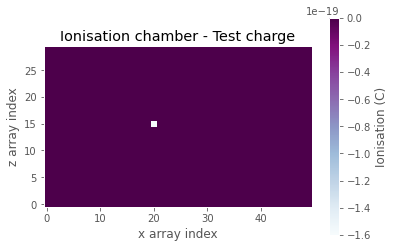

Time (s) = 0


In [16]:
# Set parameters.
tau = 1e-6 # Time step (seconds).
h = 0.01 # Grid size (metres).
Mu = 50 # electron mobility (m^2 V^-1 s^-1).

n_i = 30 # Total x indexes in grid chamber.
n_j = 50 # Total z indexes in grid chamber.

q_test = test_q(n_i, n_j) # Generate charge array.


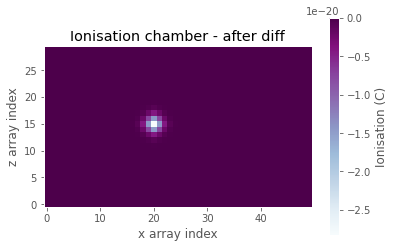

Time (s) = 0.0006


In [19]:
# Test case 1

# Diffusion only i.e E = 0.
time_total = 6e-4 # Total simulated time (seconds).
D = 0.1 # Electron diffusivity (m^2 s^-1).
E = 0 # Electric field (V m^-1).
alpha = (D*tau)/h**2 # Variable used to simplify.
beta = (tau*E)/(2*Mu*h) # Variable used to simplify.
M = M_matrix_np(n_i,n_j, alpha, beta) # Generate M matrix.
Chamber = drift_diffusion(q_test, M, time_total) # Run drift-diffusion on chamber.
plot_chamber(Chamber, ' - after diff')
print("Time (s) = " + str(time_total))

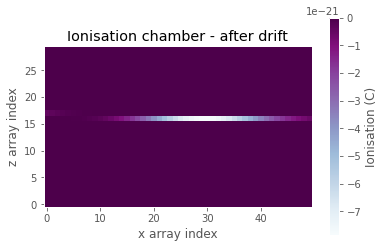

Time (s) = 0.0006


In [20]:
# Test case 2
# Drift only i.e D = 0 
time_total = 6e-4 # Total simulated time (seconds).
D = 0 # Electron diffusivity (m^2 s^-1).
E = 10**5 # Electric field (V m^-1).
alpha = (D*tau)/h**2 # Variable used to simplify.
beta = (tau*E)/(2*Mu*h) # Variable used to simplify.
M = M_matrix_np(n_i,n_j, alpha, beta) # Generate M matrix.
Chamber = drift_diffusion(q_test, M, time_total) # Run drift-diffusion on chamber.
plot_chamber(Chamber, ' - after drift')
print("Time (s) = " + str(time_total))   

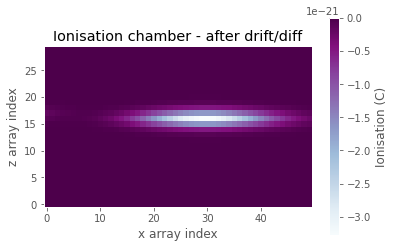

Time (s) = 0.0006


In [21]:
# Test case 3
# Drift and diffusion. 
time_total = 6e-4 # Total simulated time (seconds).
D = 0.1 # Electron diffusivity (m^2 s^-1).
E = 10**5 # Electric field (V m^-1).
alpha = (D*tau)/h**2 # Variable used to simplify.
beta = (tau*E)/(2*Mu*h) # Variable used to simplify.
M = M_matrix_np(n_i,n_j, alpha, beta) # Generate M matrix.
Chamber = drift_diffusion(q_test, M, time_total) # Run drift-diffusion on chamber.
plot_chamber(Chamber, ' - after drift/diff')
print("Time (s) = " + str(time_total))

## Part 3: Description of code.

The code in part 3 is used to solve the 2D drift-diffusion equation using an iterative matrix formulation. The finite difference equation uses the matrix M (created by the function M_matirx_np()) to calculate the drift diffusion on a test charges in 2D, represented by the test matrix generated by the function test_q().  test_q() generates a row major matrix in order to simplify the calculation and decrease run time. The M matrix is inverted using LU decomposition via scipy linalg.lu_factor(). The inverted M matrix is then iterated with the row major q matrix a number of steps equal to the total desired time (time_total) / time step (tau). This gives the q matrix of the final solution after drift and diffusion for a time = time_total, which then needs to be reshaped back into a 2D array to be graphed with .imshow(). 

A test charge is placed arbitrarily in the centre of the grid and 3 tests are then run on it. The first test is only to observe the effects of diffusion. So the electric field, E, is set to 0. This is set to run for 5e-4 seconds with a time step of 1e-6 seconds.

The second test is only to observe the effects of drift. So the electron diffusivity, D, is set to 0. This is set to run for 5e-4 seconds with a time step of 1e-6 seconds.

Finally, both drift and diffusion are tested at the same time. This is set to run for 6e-4 seconds with a time step of 1e-6 seconds.

## Part 3: Discussion of results
For the sake of comparison all tests here use the same time of 6e-4 seconds. The test charge is a single electron in an arbitrary location where behaviour can easily be observed.

### Test 1 – Diffusion only
By setting the electric field, E, to 0 it is possible to observe the test charge diffusing. Looking at the plot “Ionisation chamber – after diff” and comparing it to “Ionisation chamber – Test charge” it is qualitatively clear that diffusion has taken place, with the area around the test charge increasing with negative charge at a gradient. 

### Test 2 – Drift only
By setting the electron diffusivity, D, to 0 it is possible to observe the test charge drifting. Looking at the plot “Ionisation chamber – after drift” and comparing it to “Ionisation chamber – Test charge” it is perhaps unclear whether drift has taken place, and additionally there appears to be a smearing effect in the x direction. If we taken the point with the highest ionisation (lowest C value) to be the centre of the test charge we can see that it is drifting to the right, which is expected given a negative charge in an electric field going from right to left. This is somewhat… annoying, though it is my understanding that is an expected artifact given the method of the solution (finite difference with the M matrix).  Another unrealistic aspect to this is that it can be seen that the ionisation values wrap around, i.e., values that drift off the right of the chamber appear again on the left side. 

The smearing effect is not a small effect in the least. In fact, there is more smearing in the x direction from drift than there is from diffusion for the same time. This is very large and inconvenient consequence when using this solution. And it would be recommended to find an alternate solution here if you wanted to observe accurate visualisation of drift.

### Test 3 – Drift and Diffusion.
Consequently, in the final test we see a superposition of the drift and diffusion on the test charge. This is what we expect to see given the unfortunate qualities of the drift only section seen in test 2.



# Part 4 - Simulating the Drift Chamber

Now use the functions you have defined above to simulate the full process :
* a cosmic muon entering the drift chamber
* the initial charge distribution resulting from that cosmic muon
* the charge drifting, and diffusing, under the influence of the electric field

Run these steps for at least one cosmic ray muon, and plot the results in an appropriate format.

**Describe your code and results in this markdown cell**

Muon enters through the top (x,z): 
[-0.042277252456704544, -0.2]
Muon exits through the bottom (x,z):
[0.0697685372270468, -0.5]


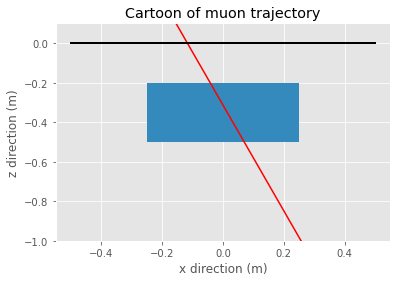

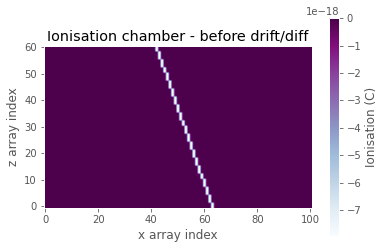

Time (s) = 0


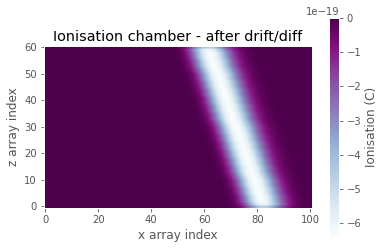

Time (s) = 0.0001


In [14]:
########### Size and placement of horizontal plane and chamber. ##############
z_0 = 0 # Height of horizontal plane, centred on the origin, m.
plane_size_x = 1 # Size of the horizontal plane in the x direction, m.
plane_size_y = 1 # Size of the horizontal plane in the y direction, m.
z_distance = 0.2 # Absolute distance of the plane to top of the chamber, m.

chamber_size_x = 0.5 # Width of the chamber, m.
chamber_size_z = 0.3 # Height of the chamber, m.


z_T = -z_distance # Top of chamber, m.
z_B = -z_distance - chamber_size_z # Bottom of chamber, m.
x_L = -chamber_size_x/2 # Left side of chamber, m.
x_R = chamber_size_x/2 # Right side of chamber, m.

##############################################################################

muon_hit_direction = 'miss'
# Keep generating muons until one intersects with the chamber.
while muon_hit_direction == 'miss':
    # Generate a muon.
    muon_unit_vector, muon_position, muon_energy  =  generate_Muon(1,1,z_0)


    # Calculate gradient and intercept of muon trajectory.
    delta_z = muon_unit_vector[2]
    delta_x = muon_unit_vector[0]
    gradient = delta_z/delta_x # Gradient of muon trajectory
    c = z_0 - (gradient * muon_position[0]) # z intercept.

    # Find potential intersecting coordinates of the muon and the chamber.
    x_T = (z_T - c)/gradient # x coordinate if z is at the top of the chamber.
    x_B = (z_B - c)/gradient # x coordinate if z is at the bottom of the chamber.
    z_R = gradient * x_R + c # z coordinate if x is at the right side of chamber.
    z_L = gradient * x_L + c # z coordinate if x is at the left side of chamber.



    # Check to see if the muon enters the chamber
    muon_hit_direction, entry_coords = check_chamber_entry(x_T, z_L, z_R)

print(entry_coords)
# Check where the muon exits the chamber.
exit_coords = check_chamber_exit(muon_hit_direction, x_B, z_L, z_R)
print(exit_coords)

# 2D plot of the muon trajectory, plane and chamber as seen from the x-z plane.
fig = plt.figure() 
ax = fig.add_subplot(111)
ax.add_patch(Rectangle((x_L, z_B), 0.5, 0.3)) # Adds the chamber as rectangle
x = np.linspace(-plane_size_x/2, plane_size_x/2,10) # Horizontal plane. 
y = gradient*x+c # Muon trajectory.

# Plot parameters
plt.plot(x, y, '-r') # Plot trajectory/
plt.plot([ -plane_size_x/2
         , plane_size_x/2]
         , [0, 0]
         , color='k'
         , linestyle='-'
         , linewidth=2) #  Plot the side view of horizontal plane.
plot_labeler('x direction (m)', 'z direction (m)', 'Cartoon of muon trajectory')
plt.ylim(top=0.1) # Keeping the graph size constant
plt.ylim(bottom=-1) # Keeping the graph size constant
plt.show()


sq_size = 0.005 # Size of grid spaceing within chamber.
electrons_per_m = 9400 # Number of electrons per metre.

# Create Argon chamber as a 2D array, representing a grid of spacing sq_size.
chamber_grid = np.zeros([ int(chamber_size_z/sq_size+1)
                        , int(chamber_size_x/sq_size)+1])

# Transform entry coordinates into indexes within a 2D array.
# This is a quantisation of the coordinate systems, followed by a
# translation of the coordinates so they are in a second reference frame,
# with the origin centered on the bottom left of the ionisation chamber.
# These quantised coordinates in the translated frame then correspond
# to the indexes within the 2D array.
index_x_init = int(chamber_size_x /(2*sq_size) + int(entry_coords[0] / sq_size))
index_z_init = int((z_distance + chamber_size_z) / sq_size) + int(entry_coords[1] / sq_size) 

# Transformed and translated entry coordinates into indexes for 2D array.
start = [index_x_init, index_z_init]

# Exit coordinates treated the same as what was done for the entry coordinates.
index_x_end = int(chamber_size_x /(2*sq_size)) + int(exit_coords[0] / sq_size)
index_z_end = int((z_distance + chamber_size_z) / sq_size) + int(exit_coords[1] / sq_size) 

# Transformed and translated exit coordinates into indexes for 2D array.
end = [index_x_end, index_z_end]

# Electron parameters
e_charge = -1.602176634e-19
e_per_m = 9400

# This impliments the contribution of the y component of the muon trajectory.
entry_point_3d = np.array([entry_coords[0], 0., entry_coords[1]])
delta_y = (exit_coords[1] - entry_coords[1]) * (muon_unit_vector[1] / muon_unit_vector[2])
exit_point_3d = np.array([exit_coords[0], delta_y, exit_coords[1]])

length = np.linalg.norm(exit_point_3d - entry_point_3d) # Length of trajectory in 3D.

# Total electrons liberated by the muon through the whole chamber.
electron_number = length * e_per_m 

# Assigns charge to grid chamber based on bresenham_line() index coordinates.
for i in range(len(bresenham_line(start, end))):
    point = bresenham_line(start, end)[i] # Index coordinates.
    x_pos = point[0] # x component of index.
    z_pos = point[1] # z component of index.

    # Allocates the average number of electrons per grid section liberated
    chamber_grid[z_pos, x_pos] = e_charge * electron_number/len(bresenham_line(start, end))  

# Plot chamber
plot_chamber(chamber_grid, ' - before drift/diff')
print("Time (s) = 0")


# Set parameters.
tau = 1e-6 # Time step (seconds).
h = sq_size # Grid size (metres).
Mu = 50 # electron mobility (m^2 V^-1 s^-1).

n_i = int(chamber_size_z/sq_size)+1 # Total x indexes in grid chamber.
n_j = int(chamber_size_x/sq_size)+1 # Total z indexes in grid chamber.

#print(len(chamber_grid))
q = chamber_grid.flatten() # Generate row major array for inversion.


# Drift and diffusion   .
time_total = 1e-4 # Total simulated time (seconds).
D = 0.1 # Electron diffusivity (m^2 s^-1).
E = 10**5 # Electric field (V m^-1).
alpha = (D*tau)/h**2 # Variable used to simplify.
beta = (tau*E)/(2*Mu*h) # Variable used to simplify.
M = M_matrix_np(n_i,n_j, alpha, beta) # Generate M matrix.
Chamber = drift_diffusion(q, M, time_total) # Run drift-diffusion on chamber.
plot_chamber(Chamber, ' - after drift/diff')
print("Time (s) = " + str(time_total))

## Part 4: Description of code.
The code in part 4 is then just bringing together part 1, 2 and 3 in order to observe the drift and diffusion of electrons in the ionisation chamber created by a muon that liberated said electrons.  

Part 2 already implements everything needed here, including the muon generation from part 1. In this case thought the grid spacing is reduced to 5mm instead of 1cm for increased resolution. The 2D array of the chamber (chamber) with the liberated electrons due to the muon is then passed onto the code from part 3, this time the test_q matrix is replaced with the 2D array (chamber). The drift-diffusion method from part 3 is then used to create a simulation of drift and diffusion on the electrons from the muon trajectory through the chamber.

## Part 4: Discussion of results
Here is just the accumulation of the previous 4 parts put together, so much of this is explained in the previous sections. Though here the grid spacing is reduced to have a higher resolution on the image and also a lower error from the Brensenham line algorithm. Instead of  attest charge the drift diffusion solution acts upon the electrons liberated by the muon passing through the chamber. The behaviour is exactly as expected given the results from parts 1, 2 and 3.  
